In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import DistanceMetric
import matplotlib.patches as patches
from scipy.spatial import ConvexHull
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from umap import umap_ as UMAP
import shap
from sklearn.ensemble import RandomForestClassifier
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from sklearn.metrics import pairwise_distances
import itertools

# Data loading and cleaning

In [2]:
df = pd.read_excel('Channel morphology.xls')
df.shape

(54, 15)

In [3]:
key = df.iloc[53]

In [4]:
df = df.loc[:52]

In [5]:
df.describe()

,Site #,Channel slope Percent,Active channel maximum depth (Meters),Active channel width (Meters),Active channel W:Dmax ratio,Riparian corridor maximum depth (Meters),Riparian corridor width (Meters),Riparian corridor W:Dmax ratio,Rocks per square meter
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,26.000000,1.301887,0.684906,12.377358,17.927358,2.064151,78.773585,41.792453,22.792453
std,15.443445,0.774222,0.195523,9.215844,9.293735,1.067545,93.005509,37.747842,21.288638
min,0.000000,0.000000,0.400000,4.000000,7.100000,0.900000,15.000000,7.400000,0.000000
25%,13.000000,1.000000,0.500000,8.000000,11.400000,1.100000,27.000000,14.300000,6.000000
50%,26.000000,1.000000,0.700000,9.000000,15.000000,2.000000,38.000000,24.500000,13.000000
75%,39.000000,2.000000,0.800000,14.000000,20.000000,2.900000,78.000000,60.000000,39.000000
max,52.000000,3.000000,1.200000,45.000000,45.000000,4.300000,500.000000,150.000000,71.000000


In [6]:
df['Geomorphic surface'] = df['Geomorphic surface'].astype(int)
df['Percent of bedrock in channel'] = df['Percent of bedrock in channel'].astype(int)
df['Flow frequency'] = df['Flow frequency'].astype(int)
df['Bank height ratio'] = df['Bank height ratio'].astype(float)
df['Number of lower order drainages entering channel'] = df['Number of lower order drainages entering channel'].astype(int)
df['Caliche development in channel banks'] = df['Caliche development in channel banks'].astype(int)

In [7]:
df['Geomorphic surface'] = df['Geomorphic surface'].astype(object)

In [8]:
#df.rename(columns = {'Site #' : 'distance'}, inplace = True)
df.drop(columns = 'Site #', inplace = True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 14 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Geomorphic surface                                53 non-null     object 
 1   Channel slope Percent                             53 non-null     float64
 2   Active channel maximum depth (Meters)             53 non-null     float64
 3   Active channel width (Meters)                     53 non-null     float64
 4   Active channel W:Dmax ratio                       53 non-null     float64
 5   Riparian corridor maximum depth (Meters)          53 non-null     float64
 6   Riparian corridor width (Meters)                  53 non-null     float64
 7   Riparian corridor W:Dmax ratio                    53 non-null     float64
 8   Percent of bedrock in channel                     53 non-null     int64  
 9   Flow frequency         

# Data distribution

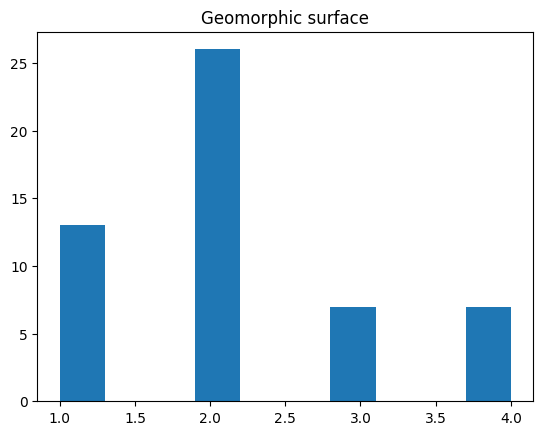

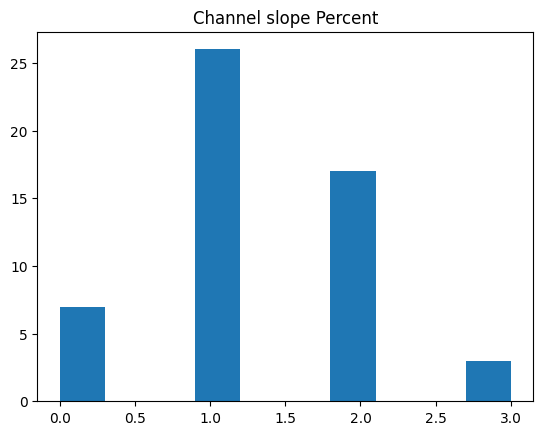

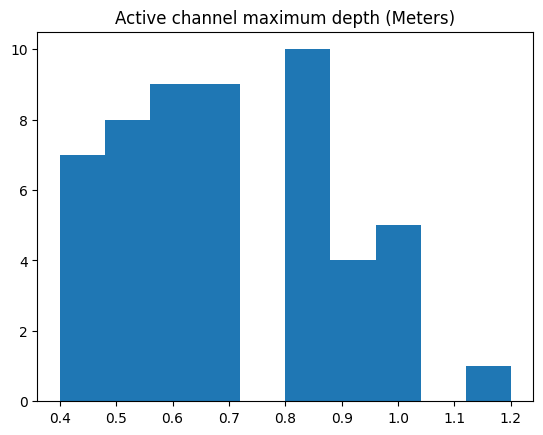

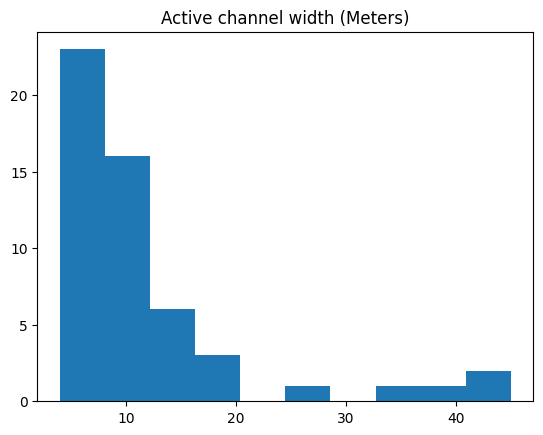

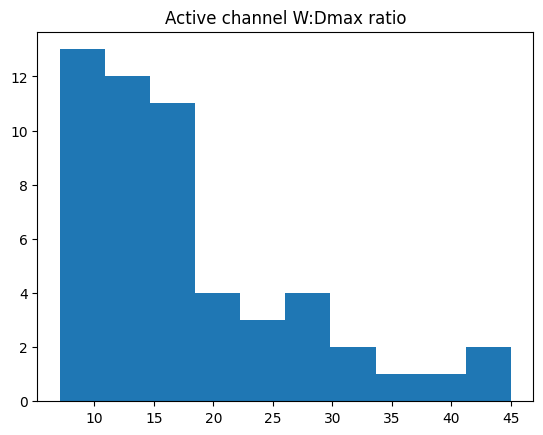

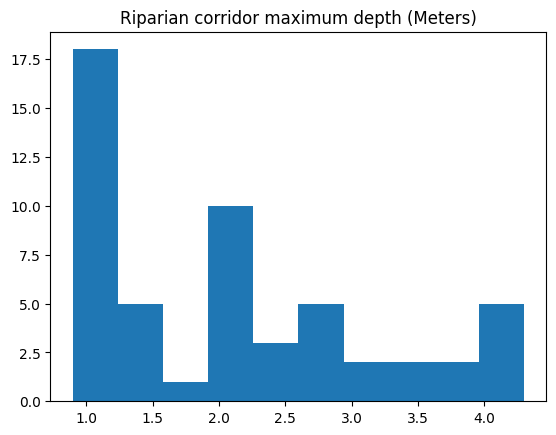

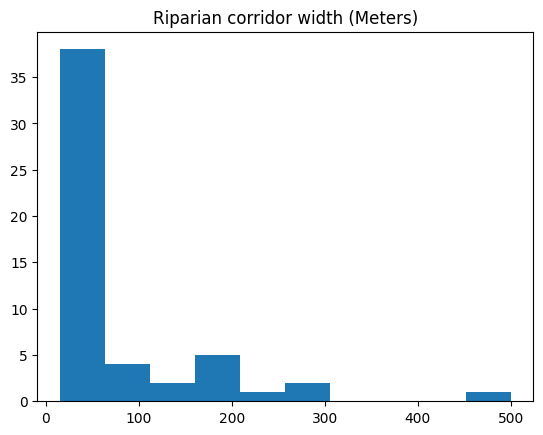

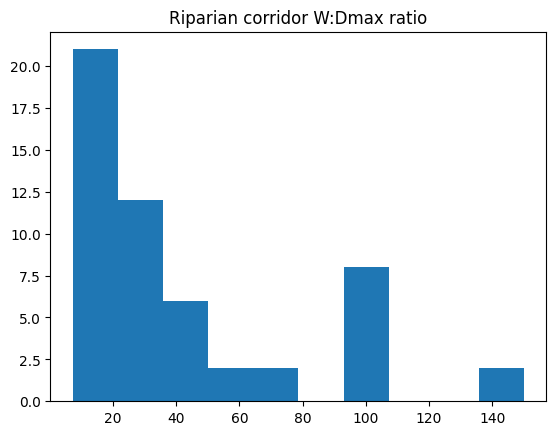

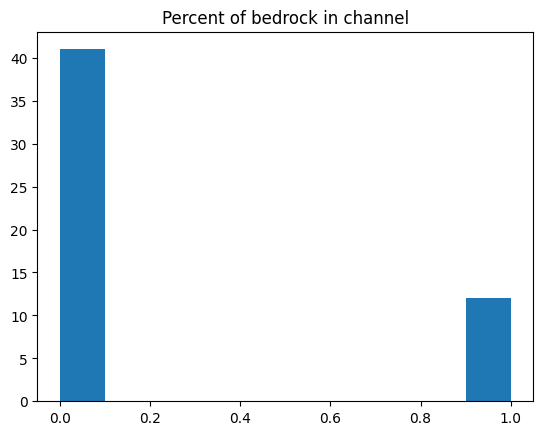

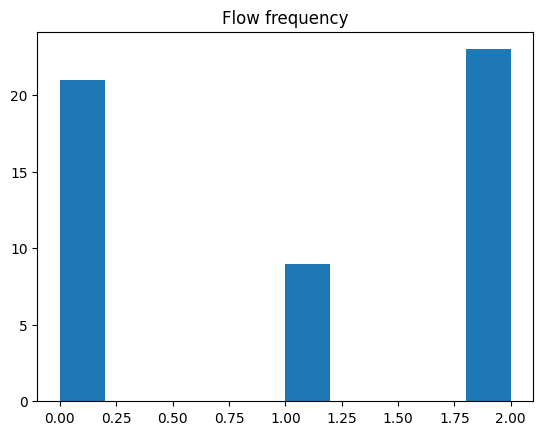

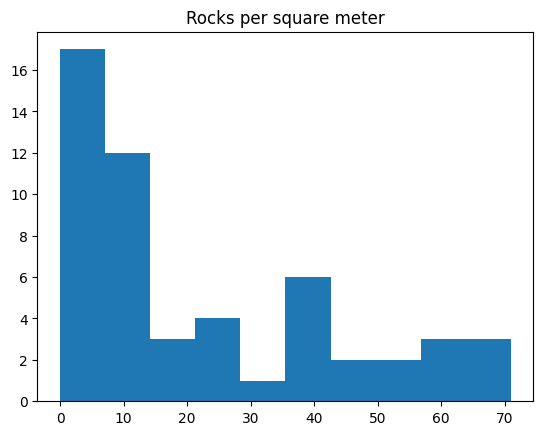

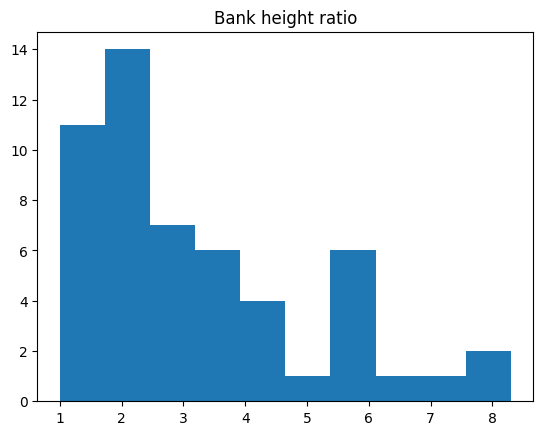

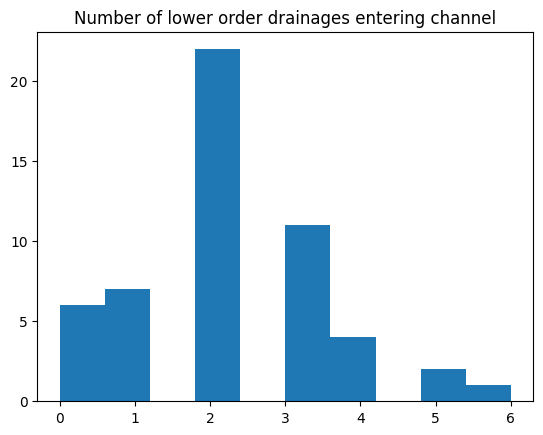

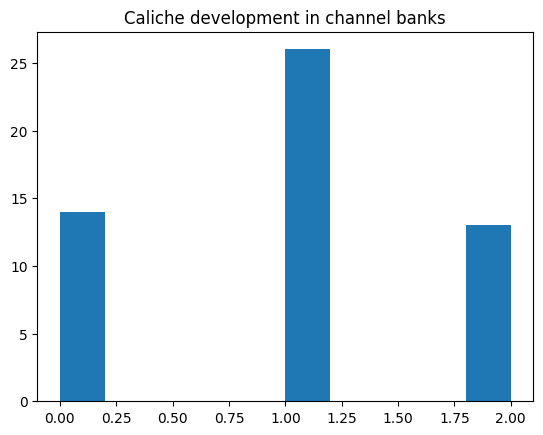

In [10]:
for i in df.columns:
    plt.hist(df[i])
    plt.title(i)
    plt.show()

In [11]:
log_cols = ['Active channel width (Meters)', 'Active channel W:Dmax ratio', 
            'Riparian corridor maximum depth (Meters)', 'Riparian corridor width (Meters)', 
            'Riparian corridor W:Dmax ratio', 'Rocks per square meter', 'Bank height ratio']
df.loc[51, 'Rocks per square meter'] = 1

In [12]:
log_df = pd.DataFrame()
for i in log_cols:
    log_df[i] = np.log(df[i])

In [13]:
trans_df = pd.concat([df[['Geomorphic surface', 'Channel slope Percent', 
               'Percent of bedrock in channel', 'Active channel maximum depth (Meters)']], log_df], axis = 1)

In [14]:
cols = ['Channel slope Percent',
       'Active channel maximum depth (Meters)',
       'Active channel width (Meters)', 'Active channel W:Dmax ratio',
       'Riparian corridor maximum depth (Meters)',
       'Riparian corridor width (Meters)', 'Riparian corridor W:Dmax ratio',
       'Percent of bedrock in channel', 
       'Rocks per square meter', 'Bank height ratio']

scaler = StandardScaler()

#scaled_data = scaler.fit_transform(trans_df[cols])
scaled_data = scaler.fit_transform(df[cols])

In [15]:
scaled = pd.DataFrame(scaled_data)
scaled.columns = cols
scaled['Geomorphic surface'] = df['Geomorphic surface']
#scaled['Caliche development in channel banks'] = df['Caliche development in channel banks']
scaled.shape

(53, 11)

# PCA

In [16]:
pca = PCA(n_components=3)
pca.fit(scaled)
pcax = pca.transform(scaled)
pcax.shape

(53, 3)

In [17]:
pca_df = pd.DataFrame(pcax)
pca_df.columns = ['pca0', 'pca1', 'pca2']
pca_df['Geomorphic surface'] = df['Geomorphic surface']
pca_df.head()

,pca0,pca1,pca2,Geomorphic surface
0,4.775687,1.611297,-0.482369,1
1,4.541203,1.474409,-0.406121,1
2,4.283522,1.538843,-0.906831,1
3,4.051906,1.494654,0.624971,1
4,3.906919,1.480587,-0.251344,1


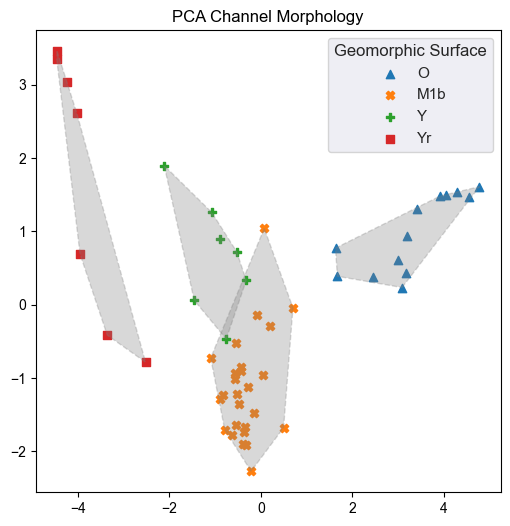

In [18]:
labels = pca_df['Geomorphic surface'].unique()

fig, ax = plt.subplots(figsize = (6,6))
sns.set()

for label, l, s in zip(labels, ['O', 'M1b', 'Y', 'Yr'], ['^', 'X', 'P', ',']):
    group_df = pca_df[pca_df['Geomorphic surface'] == label]
    points = group_df[['pca0', 'pca1']].values
    ax.scatter(group_df['pca0'], group_df['pca1'], label = l, edgecolor = None, marker = s)
    if len(points) > 2:
        hull = ConvexHull(points)
        polygon_points = points[hull.vertices]
        poly = patches.Polygon(polygon_points, alpha = 0.3, fill = True, linestyle ='--', color = 'gray')
        ax.add_patch(poly)
        
plt.legend(title = 'Geomorphic Surface')
plt.title('PCA Channel Morphology')
plt.show()

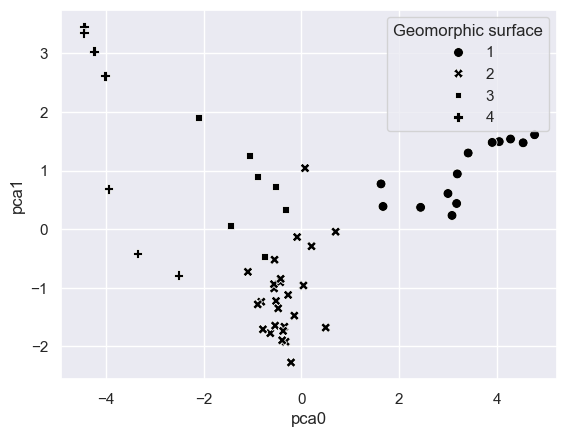

In [19]:
sns.scatterplot(x = 'pca0', y = 'pca1', data = pca_df, style = 'Geomorphic surface', s = 50, color = 'black')
plt.show()

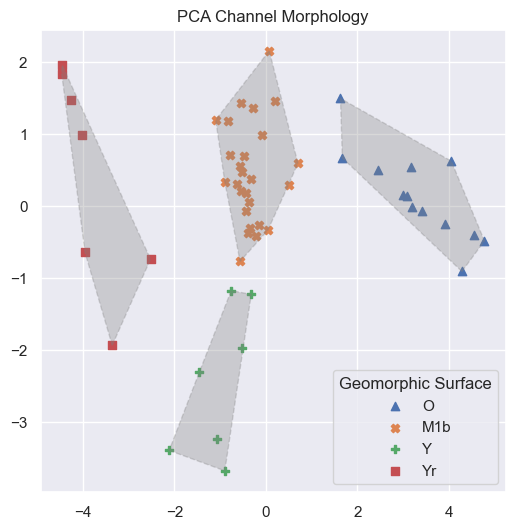

In [20]:
labels = pca_df['Geomorphic surface'].unique()

fig, ax = plt.subplots(figsize = (6,6))
sns.set()

for label, l, s in zip(labels, ['O', 'M1b', 'Y', 'Yr'], ['^', 'X', 'P', ',']):
    group_df = pca_df[pca_df['Geomorphic surface'] == label]
    points = group_df[['pca0', 'pca2']].values
    ax.scatter(group_df['pca0'], group_df['pca2'], label = l, edgecolor = None, marker = s)
    if len(points) > 2:
        hull = ConvexHull(points)
        polygon_points = points[hull.vertices]
        poly = patches.Polygon(polygon_points, alpha = 0.3, fill = True, linestyle ='--', color = 'gray')
        ax.add_patch(poly)
        
plt.legend(title = 'Geomorphic Surface')
plt.title('PCA Channel Morphology')
plt.show()

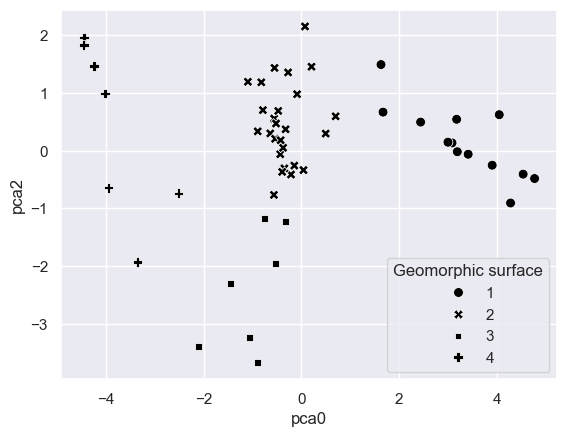

In [21]:
sns.scatterplot(x = 'pca0', y = 'pca2', data = pca_df, style = 'Geomorphic surface', color = 'black', s = 50)
plt.show()

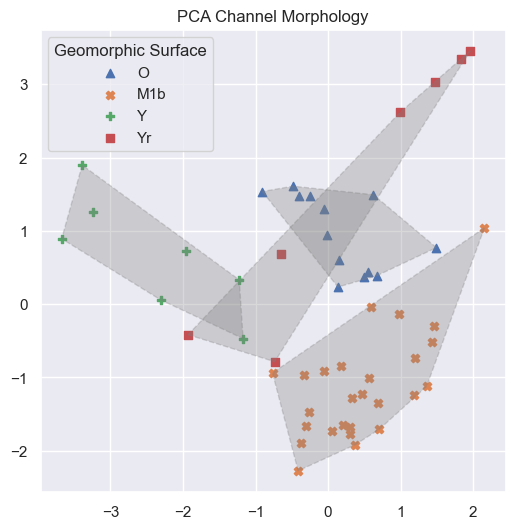

In [22]:
labels = pca_df['Geomorphic surface'].unique()

fig, ax = plt.subplots(figsize = (6,6))
sns.set()

for label, l, s in zip(labels, ['O', 'M1b', 'Y', 'Yr'], ['^', 'X', 'P', ',']):
    group_df = pca_df[pca_df['Geomorphic surface'] == label]
    points = group_df[['pca2', 'pca1']].values
    ax.scatter(group_df['pca2'], group_df['pca1'], label = l, edgecolor = None, marker = s)
    if len(points) > 2:
        hull = ConvexHull(points)
        polygon_points = points[hull.vertices]
        poly = patches.Polygon(polygon_points, alpha = 0.3, fill = True, linestyle ='--', color = 'gray')
        ax.add_patch(poly)
        
plt.legend(title = 'Geomorphic Surface')
plt.title('PCA Channel Morphology')
plt.show()

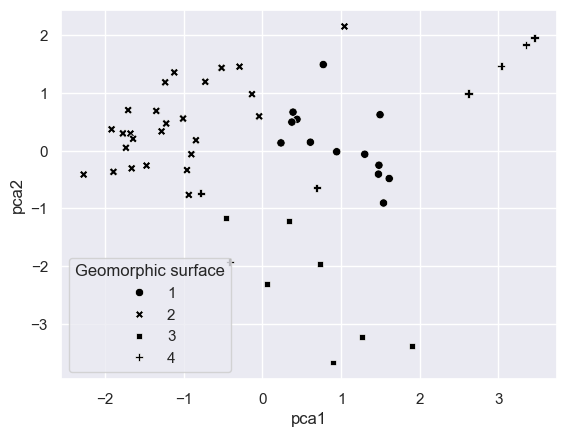

In [23]:
sns.scatterplot(x = 'pca1', y = 'pca2', data = pca_df, style = 'Geomorphic surface', color = 'black')
plt.show()

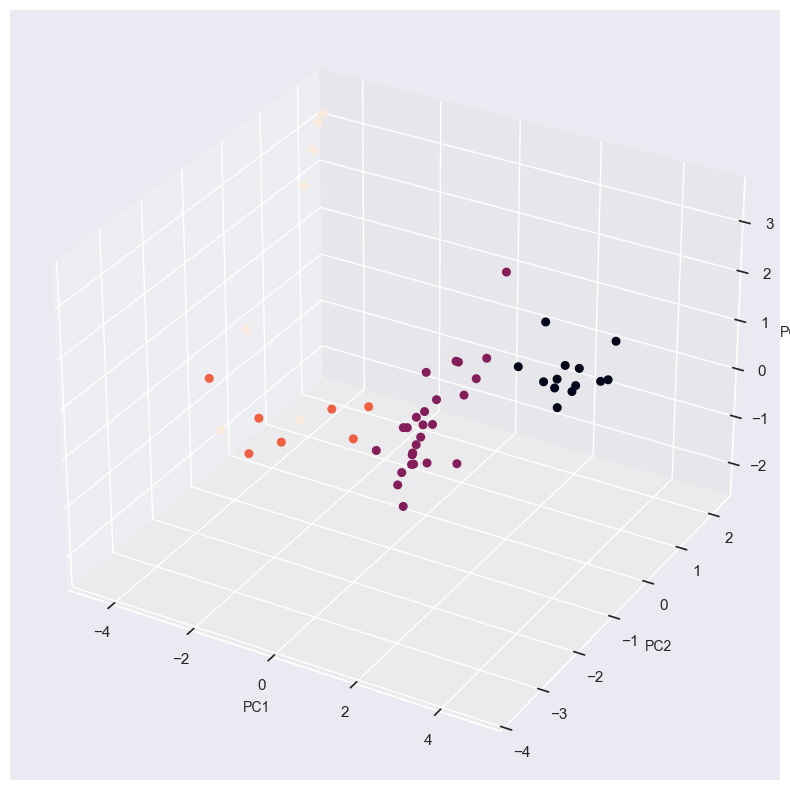

In [24]:
fig = plt.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(pca_df['pca0'], pca_df['pca2'], pca_df['pca1'], c = pca_df['Geomorphic surface'], alpha = 1, s = 30)
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)
plt.show()

In [25]:
pca.explained_variance_ratio_

array([0.48445823, 0.18921119, 0.14826901])

In [26]:
pca.explained_variance_ratio_.sum()

np.float64(0.8219384328178732)

# MDS

In [27]:
mds = MDS(n_components = 2, max_iter = 10000, metric = True)

mdsx = mds.fit_transform(scaled)
mds_df = pd.DataFrame(mdsx)
mds_df.columns = ['mds0', 'mds1']
mds_df['Geomorphic surface'] = df['Geomorphic surface']
mds.stress_

C:\Users\matta\anaconda3\envs\modeling_env\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


np.float64(917.954647690736)

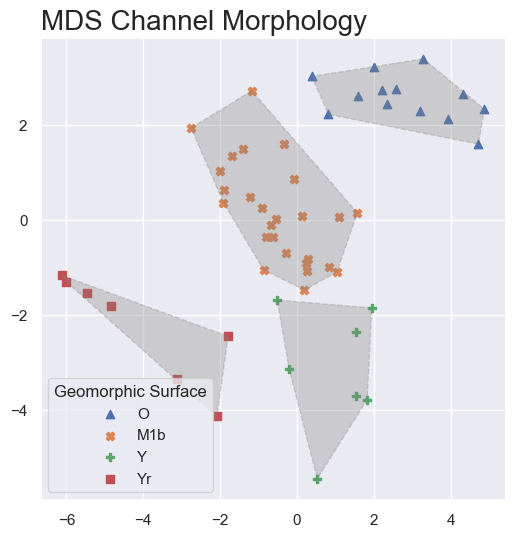

In [28]:
labels = mds_df['Geomorphic surface'].unique()

fig, ax = plt.subplots(figsize = (6,6))
sns.set()

for label, l, s in zip(labels, ['O', 'M1b', 'Y', 'Yr'], ['^', 'X', 'P', ',']):
    group_df = mds_df[mds_df['Geomorphic surface'] == label]
    points = group_df[['mds0', 'mds1']].values
    ax.scatter(group_df['mds0'], group_df['mds1'], label = l, edgecolor = None, marker = s)
    if len(points) > 2:
        hull = ConvexHull(points)
        polygon_points = points[hull.vertices]
        poly = patches.Polygon(polygon_points, alpha = 0.3, fill = True, linestyle ='--', color = 'gray')
        ax.add_patch(poly)
        
plt.legend(title = 'Geomorphic Surface')
plt.title('MDS Channel Morphology', loc = 'left', fontsize = '20')
plt.show()

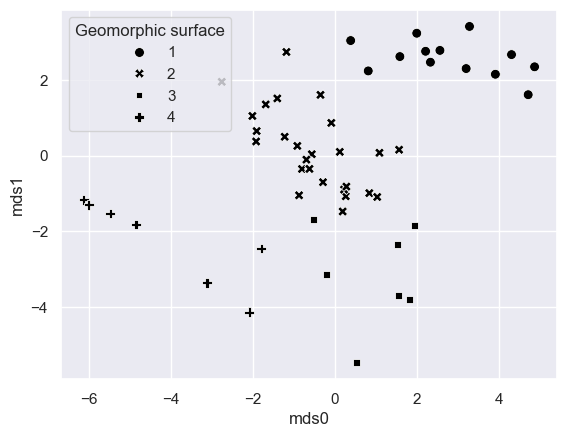

In [29]:
sns.scatterplot(x = 'mds0', y = 'mds1', data = mds_df, style = 'Geomorphic surface', s = 50, color = 'black')
#plt.xlim(-100, 200)
plt.show()

In [30]:
scaler = StandardScaler()
scaled_trans_df = scaler.fit_transform(trans_df)

In [31]:
mds = MDS(n_components = 2, max_iter = 10000, metric = True, dissimilarity = 'precomputed')

dist = DistanceMetric.get_metric('braycurtis')
#dist = DistanceMetric.get_metric('euclidean')

#mdsx = pd.DataFrame(mds.fit_transform(dist.pairwise(df[cols])))
#mdsx = pd.DataFrame(mds.fit_transform(dist.pairwise(scaled_data)))
mdsx = pd.DataFrame(mds.fit_transform(dist.pairwise(trans_df)))
#mdsx = pd.DataFrame(mds.fit_transform(dist.pairwise(scaled_trans_df)))
mds.stress_

C:\Users\matta\anaconda3\envs\modeling_env\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


np.float64(0.9072005972377231)

In [32]:
mdsx.columns = ['b-mds0', 'b-mds1']
mdsx['Geomorphic surface'] = df['Geomorphic surface']

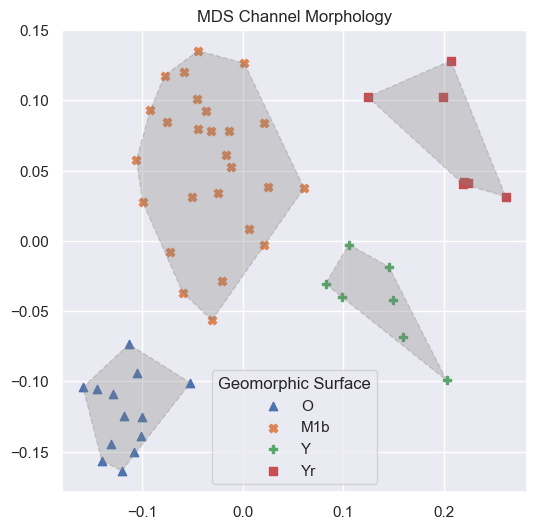

In [55]:
labels = mdsx['Geomorphic surface'].unique()

fig, ax = plt.subplots(figsize = (6,6))
sns.set()

for label, l, s in zip(labels, ['O', 'M1b', 'Y', 'Yr'], ['^', 'X', 'P', ',']):
    group_df = mdsx[mdsx['Geomorphic surface'] == label]
    points = group_df[['b-mds0', 'b-mds1']].values
    ax.scatter(group_df['b-mds0'], group_df['b-mds1'], label = l, edgecolor = None, marker = s)
    if len(points) > 2:
        hull = ConvexHull(points)
        polygon_points = points[hull.vertices]
        poly = patches.Polygon(polygon_points, alpha = 0.3, fill = True, linestyle ='--', color = 'gray')
        ax.add_patch(poly)
        
plt.legend(title = 'Geomorphic Surface')
plt.title('MDS Channel Morphology')
plt.savefig("channel_morphology.png", dpi=300, bbox_inches="tight")
plt.show()

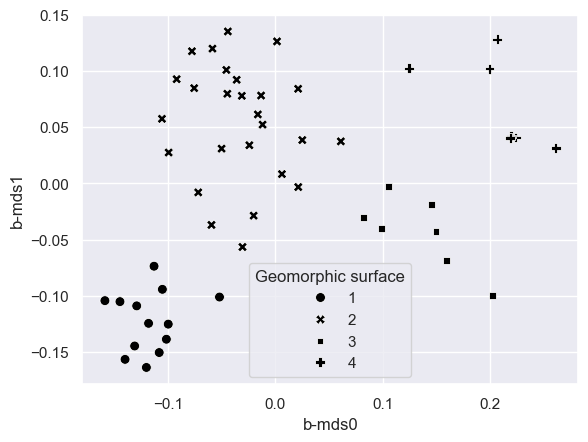

In [34]:
sns.scatterplot(x = 'b-mds0', y = 'b-mds1', data = mdsx, style = 'Geomorphic surface', s = 50, color = 'black')
plt.show()

# Hierarchical clustering

In [35]:
#distances = pdist(scaled, metric = 'braycurtis')
#linked = linkage(scaled, method = 'ward', metric = 'euclidean')  #average, ward, weighted, euclidean
linked = linkage(trans_df, method = 'ward', metric = 'euclidean')
#labels = scaled['Geomorphic surface'].values.tolist()
labels = trans_df['Geomorphic surface'].values.tolist()

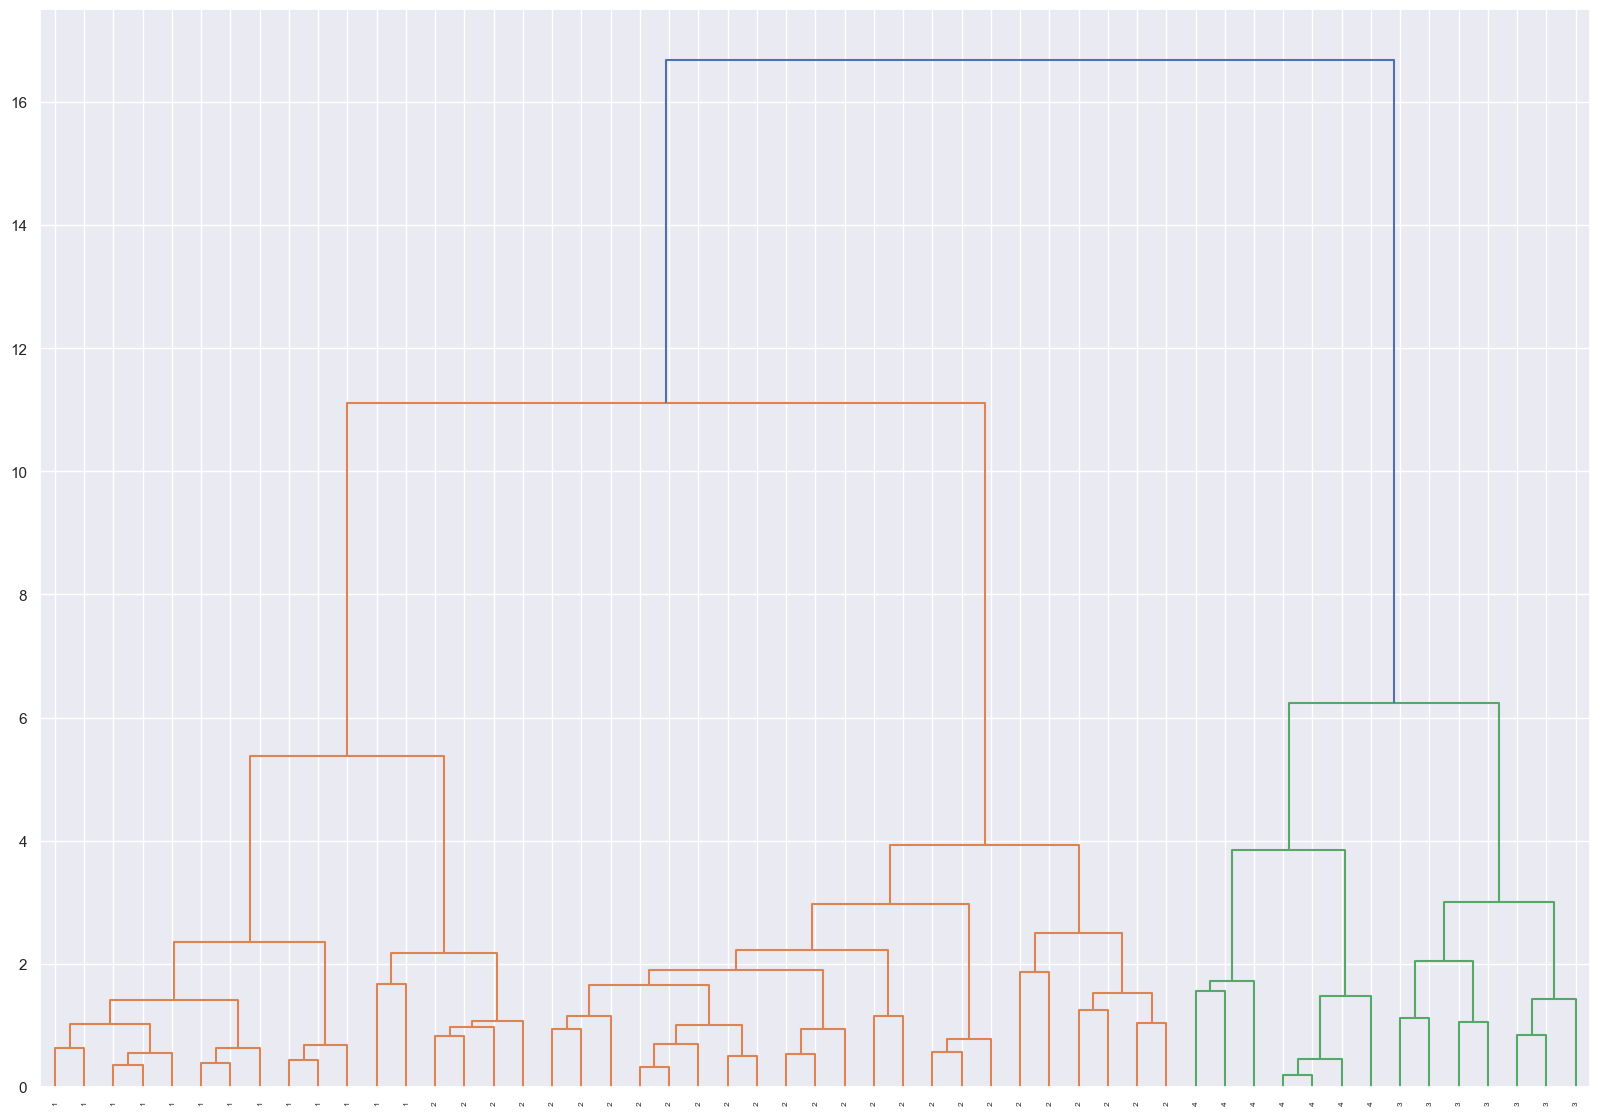

In [36]:
plt.figure(figsize = (20,14))
dendrogram(linked, orientation = 'top', distance_sort = 'descending', labels = labels, show_leaf_counts = True)
plt.show()

# Hypothesis testing PERMANOVA

In [37]:
# Distance matrix
bc = pairwise_distances(trans_df, metric="braycurtis")
bc_dm = DistanceMatrix(bc, ids=trans_df.index)

# PERMANOVA
all_results = permanova(bc_dm, grouping=df['Geomorphic surface'].values, permutations=999)
all_results

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      53
number of groups                  4
test statistic            63.018172
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [38]:
groups = df['Geomorphic surface'].unique()

results = []

for g1, g2 in itertools.combinations(groups, 2):
    ids = df[df['Geomorphic surface'].isin([g1, g2])].index
    sub_dm = bc_dm.filter(ids, strict=False)
    grouping = df.loc[ids, 'Geomorphic surface'].values
    #PERMANOVA
    res = permanova(sub_dm, grouping=grouping, permutations=999)
    print("surface", g1, "and surface", g2, "test stat", res["test statistic"], 'p-value', res['p-value'])

surface 1 and surface 2 test stat 62.096688209867665 p-value 0.001
surface 1 and surface 3 test stat 117.40304346328023 p-value 0.001
surface 1 and surface 4 test stat 198.7313893296095 p-value 0.001
surface 2 and surface 3 test stat 32.648000988355 p-value 0.001
surface 2 and surface 4 test stat 51.4239000398976 p-value 0.001
surface 3 and surface 4 test stat 19.018073619452593 p-value 0.003


# Random Forest 

In [39]:
y = df['Geomorphic surface'].astype(int)
#y = df['Geomorphic surface3-4']
X = scaled[['Channel slope Percent', 'Active channel maximum depth (Meters)',
       'Active channel width (Meters)', 'Active channel W:Dmax ratio',
       'Riparian corridor maximum depth (Meters)',
       'Riparian corridor width (Meters)', 'Riparian corridor W:Dmax ratio',
       'Percent of bedrock in channel', 'Rocks per square meter', 'Bank height ratio',]]
       #'Caliche development in channel banks']]

In [40]:
rfc = RandomForestClassifier()
rfc.fit(X, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [41]:
rfc.score(X, y)

1.0

In [42]:
importance = pd.DataFrame()
importance['feature'] = X.columns
importance['importance'] = rfc.feature_importances_
importance.sort_values('importance', ascending = False)

,feature,importance
6,Riparian corridor W:Dmax ratio,0.181464
5,Riparian corridor width (Meters),0.159021
4,Riparian corridor maximum depth (Meters),0.155338
7,Percent of bedrock in channel,0.124611
9,Bank height ratio,0.119666
0,Channel slope Percent,0.100444
8,Rocks per square meter,0.097212
2,Active channel width (Meters),0.034795
3,Active channel W:Dmax ratio,0.017357
1,Active channel maximum depth (Meters),0.010092


In [43]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X)

In [44]:
exp = shap.Explanation(shap_values[:,:,0], data = X, feature_names=X.columns)

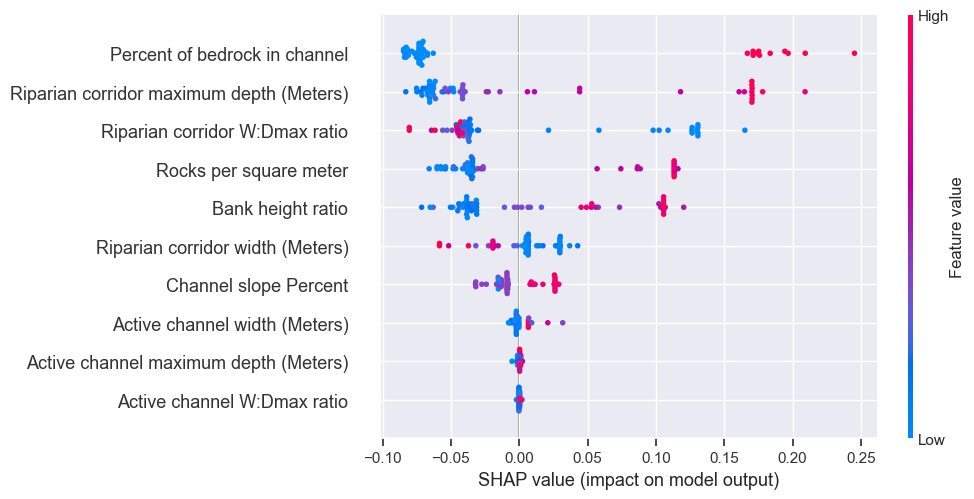

In [45]:
shap.plots.beeswarm(exp)

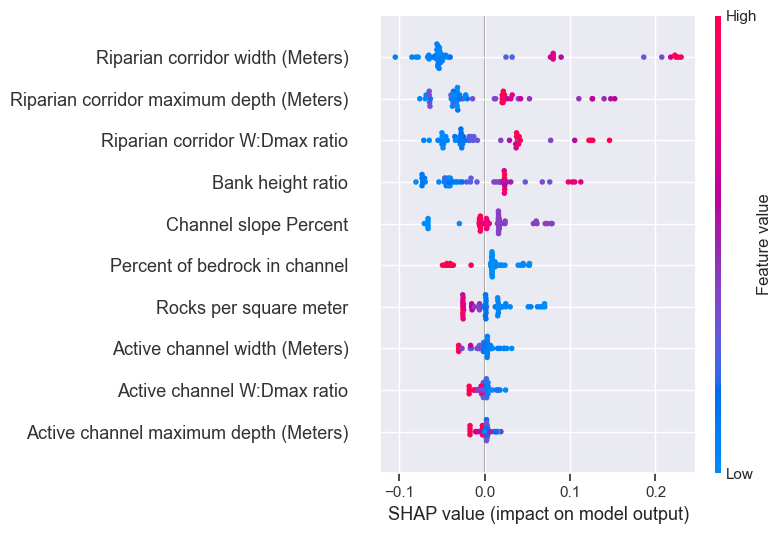

In [46]:
shap.summary_plot(shap_values[:, :, 2], X, class_names = rfc.classes_)

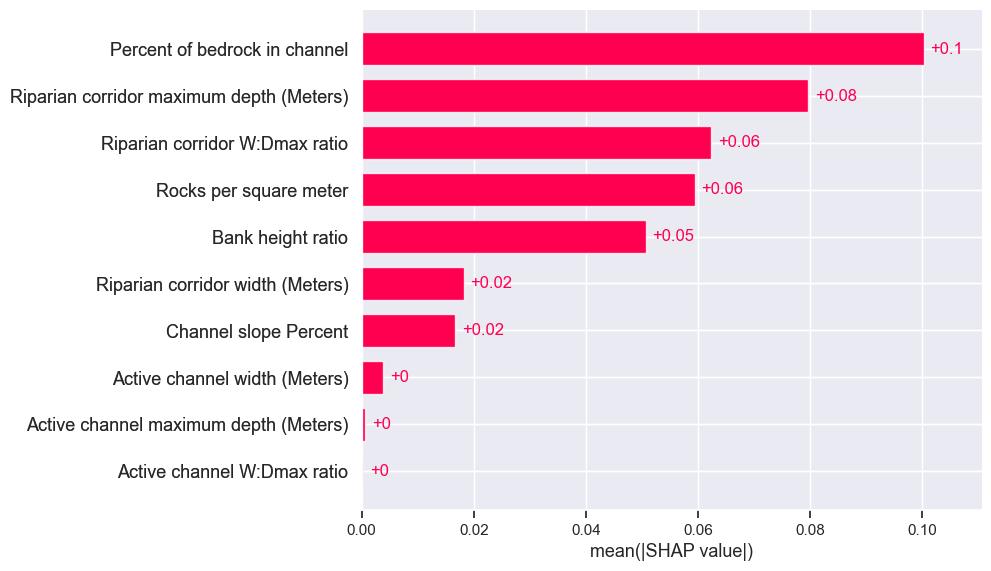

In [47]:
shap.plots.bar(exp)
plt.show()

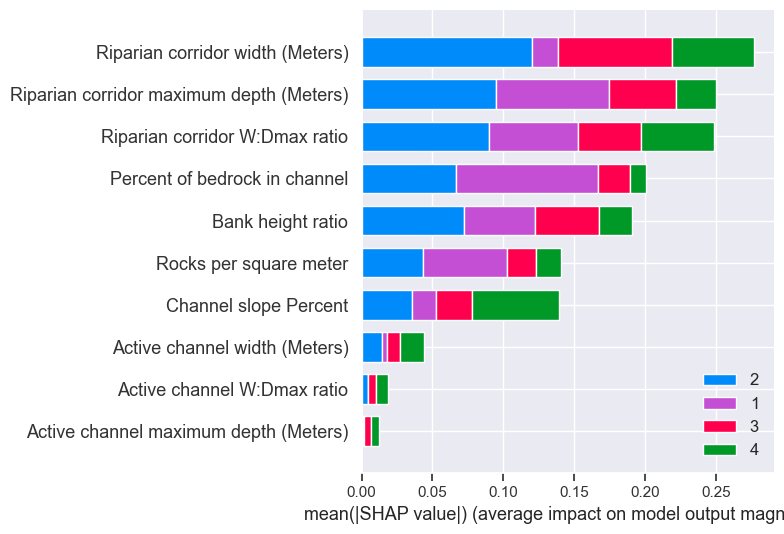

In [48]:
exp = explainer(X)

shap.summary_plot(exp, X, plot_type="bar", class_names=[1, 2, 3, 4], feature_names=X.columns)

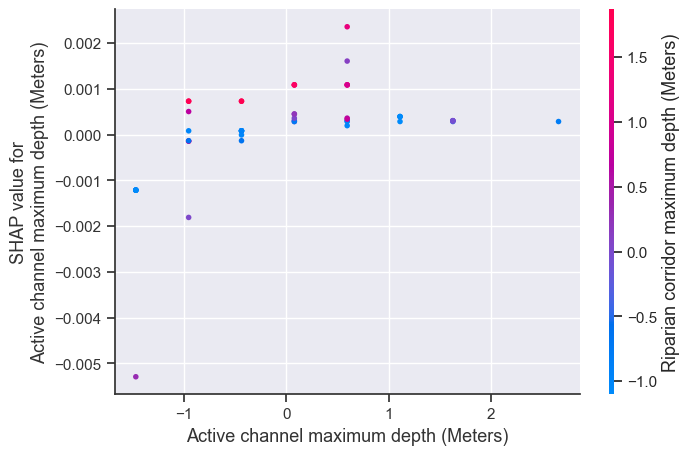

In [49]:
shap.dependence_plot(1, shap_values[:,:,0], X, feature_names=X.columns)

In [50]:
s_2d = UMAP.UMAP(n_components = 2, n_neighbors = 13, min_dist=0).fit_transform(shap_values[:, :, 1])
shap_2d = pd.DataFrame(s_2d)
shap_2d['Geomorphic surface'] = y

C:\Users\matta\AppData\Local\Temp\ipykernel_10896\3731495591.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(shap_2d['Geomorphic surface'].unique()))


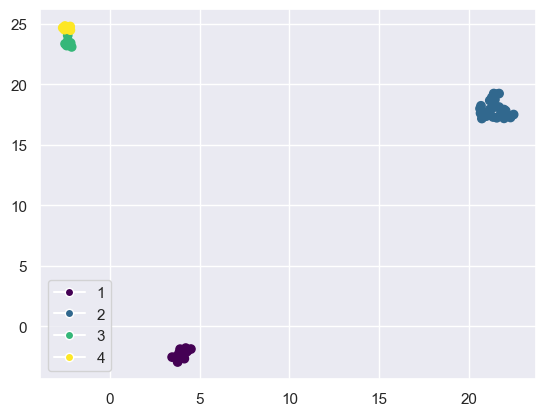

In [51]:
cmap = plt.cm.get_cmap('viridis', len(shap_2d['Geomorphic surface'].unique()))
categories = shap_2d['Geomorphic surface'].unique()
colors = [cmap(i) for i in range(len(categories))]
color_map = dict(zip(categories, colors))

plt.scatter(s_2d[:,0], s_2d[:,1], c = shap_2d['Geomorphic surface'].map(color_map))
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[c], label=c) for c in categories])
plt.show()

In [52]:
X_2d = UMAP.UMAP(n_components = 2, n_neighbors = 13, min_dist=0).fit_transform(X)
X_2d = pd.DataFrame(X_2d)
X_2d['Geomorphic surface'] = y

C:\Users\matta\AppData\Local\Temp\ipykernel_10896\3603116018.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(X_2d['Geomorphic surface'].unique()))


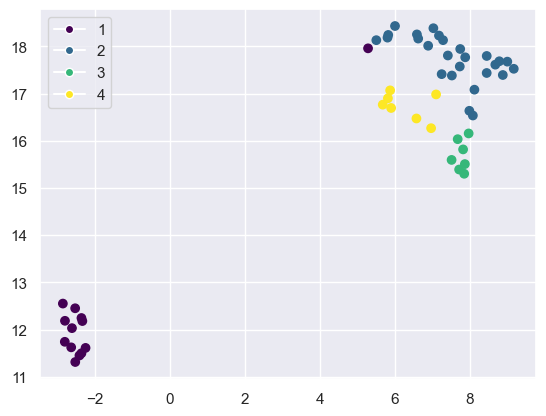

In [53]:
cmap = plt.cm.get_cmap('viridis', len(X_2d['Geomorphic surface'].unique()))
categories = X_2d['Geomorphic surface'].unique()
colors = [cmap(i) for i in range(len(categories))]
color_map = dict(zip(categories, colors))

plt.scatter(X_2d[0], X_2d[1], c = X_2d['Geomorphic surface'].map(color_map))
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[c], label=c) for c in categories])
plt.show()